# Redes Convolucionales: Proyecto 4

*Integrantes: Paula Lorena López & Manuela Acosta Fajardo*

### Introducción 

Las redes convolucionales son redes neuronales en las cuales las neuronas artificiales corresponden a campos receptivos, de manera similar a las neuronas en la corteza visual primaria (V1) de un cerebro biológico. (Cita al final). Este tipo de redes son muy efectivas para tareas de visión por computadora, como lo es la clasificación y la segmentación de imágenes.

Por otro lado, la localización de imágenes es otra de las tareas realizadas en la visión por computadora. A través de este proyecto se implementa una red convoluciona para conseguir la localización de imágenes. Estas imágenes son sacadas de una data set con fotos de animales. Se sigue el código y la explicación encontrados en el siguiente [link](https://towardsdatascience.com/object-localization-using-pre-trained-cnn-models-such-as-mobilenet-resnet-xception-f8a5f6a0228d).


### Importación de librerías 

En primer lugar, importamos las librerías y todo lo necesario para trabajar en el proyecto. Además, se define el objeto `Detection`.

In [4]:
from collections import namedtuple
import csv
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
from collections import namedtuple
import numpy as np
import cv2
Detection = namedtuple("Detection", ["image_path", "gt", "pred"])
from PIL import Image, ImageOps
import xml.etree.ElementTree as ET

### Importación de datos

Ahora, cargamos la información con la que vamos a trabajar. Primero, cargamos las imágenes, y posteriormente, las anotaciones, que nos darán la información necesaria de qué contiene cada imagen. Además, definimos el tamaño del target.

In [5]:
data_images = 'images'
data_ClassList = 'annotations/list.txt'
data_xmlAnnotations = 'annotations/xmls'
TARGET_SIZE = (224, 224)

### Definición del Bounding Box

El BoundingBox, o cuadro delimitador, hace referencia a la delimitación de los límites de un objeto dentro de la imagen. En este caso, delimitará las caras de los animales. Creamos el boundingbox de la siguiente manera. Además, se crea una función que lee el archivo .xml de anotaciones, y retorna los valores de los límites correspondientes al boundingbox de cada imagen. 

In [6]:
Bounding_Box = namedtuple('Bounding_Box', 'xmin ymin xmax ymax')
def building_bounding_box(path_to_xml_annotation):
    tree = ET.parse(path_to_xml_annotation)
    root = tree.getroot()
    path_to_box = './object/bndbox/'
    xmin = int(root.find(path_to_box + "xmin").text)
    ymin = int(root.find(path_to_box + "ymin").text)
    xmax = int(root.find(path_to_box + "xmax").text)
    ymax = int(root.find(path_to_box + "ymax").text)
    return Bounding_Box(xmin, ymin, xmax, ymax)

### Re definiendo el tamaño de las imágenes

Se crea, también, una función que nos permite re definir el tamaño de las imágenes. Esta, de ser necesaria, crea un padding para añadir pixeles. 

In [7]:
def resize_image_with_bounds(path_to_image, bounding_box=None, target_size=None):
    image = Image.open(path_to_image)
    width, height = image.size
    w_pad = 0
    h_pad = 0
    bonus_h_pad = 0
    bonus_w_pad = 0
    if width > height:
        pix_diff = (width - height)
        h_pad = pix_diff // 2
        bonus_h_pad = pix_diff % 2
    elif height > width:
        pix_diff = (height - width)
        w_pad = pix_diff // 2
        bonus_w_pad = pix_diff % 2
    image = ImageOps.expand(image, (w_pad, h_pad, w_pad+bonus_w_pad, h_pad+bonus_h_pad))
    if bounding_box is not None:
        new_xmin = bounding_box.xmin + w_pad
        new_xmax = bounding_box.xmax + w_pad
        new_ymin = bounding_box.ymin + h_pad
        new_ymax = bounding_box.ymax + h_pad
    if target_size is not None:
        width, height = image.size
        image = image.resize(target_size)
        width_scale = target_size[0] / width
        height_scale = target_size[1] / height
    if bounding_box is not None:
        new_xmin = new_xmin * width_scale
        new_xmax = new_xmax * width_scale
        new_ymin = new_ymin * height_scale
        new_ymax = new_ymax * height_scale
    image_data = np.array(image.getdata()).reshape(image.size[0], image.size[1], 3)
    if bounding_box is None:
        return image_data, None
    return (image_data, Bounding_Box(new_xmin, new_ymin, new_xmax, new_ymax))

In [8]:
def setting_sample_from_name(sample_name):
    path_to_image = os.path.join(data_images, sample_name + '.jpg')
    path_to_xml = os.path.join(data_xmlAnnotations, sample_name + '.xml')
    original_bounding_box = building_bounding_box(path_to_xml)
    image_data, bounding_box = resize_image_with_bounds(path_to_image, original_bounding_box, TARGET_SIZE)
    return (image_data, bounding_box)

### Visualización de imágenes con Bounding Box

Ahora, se crea una función que permite visualizar la imagen con el cuadro correspondiente al bounding box encima. 

In [9]:
def plot_with_box(image_data, bounding_box, compare_box=None):
    fig,ax = plt.subplots(1, figsize=(8,8))
    ax.imshow(image_data)
    boxA = patches.Rectangle((bounding_box.xmin, bounding_box.ymin),
    bounding_box.xmax - bounding_box.xmin,
    bounding_box.ymax - bounding_box.ymin,
    linewidth=3, edgecolor='y', facecolor='none')
    ax.add_patch(boxA)
    if compare_box is not None:
        boxB = patches.Rectangle((compare_box.xmin, compare_box.ymin),
        compare_box.xmax - compare_box.xmin,
        compare_box.ymax - compare_box.ymin,
        linewidth=2, edgecolor='b', facecolor='none')
        ax.add_patch(boxB)
        xA = max(bounding_box.xmin, compare_box.xmin)
        yA = max(bounding_box.ymin, compare_box.ymin)
        xB = min(bounding_box.xmax, compare_box.xmax)
        yB = max(bounding_box.ymax, compare_box.ymax)
        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
        boxAArea = (bounding_box.xmax - bounding_box.xmin + 1) * (bounding_box.ymax - bounding_box.ymin + 1)
        boxBArea = (compare_box.xmax - compare_box.xmin + 1) * (compare_box.ymax - compare_box.ymin + 1)
        iou =interArea/float(boxAArea+boxBArea-interArea)
        print('intersection of union =',iou)
    plt.show()

### Visualización de resultados

A continuación se puede observar cómo funciona lo implementado anteriormente, con un ejemplo de una imagen, y el bounding box identificando dónde se encuentra ubicada la cara del animal.

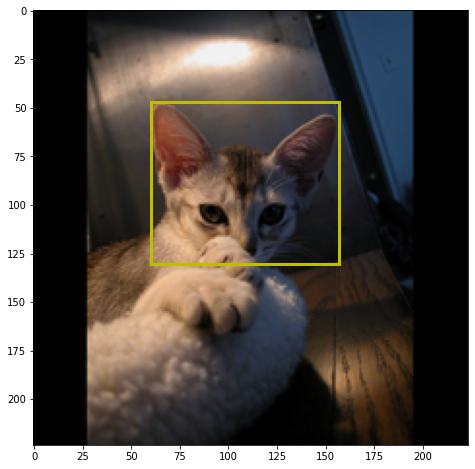

In [52]:
sample_name = 'Abyssinian_10'
image, bounding_box = setting_sample_from_name(sample_name)
b = plot_with_box(image, bounding_box)

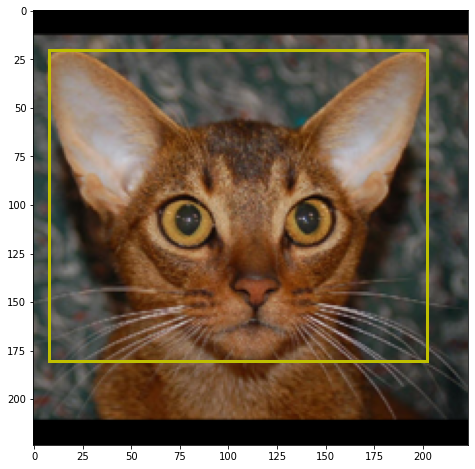

In [48]:
sample_name = 'Abyssinian_15'
image, bounding_box = setting_sample_from_name(sample_name)
c = plot_with_box(image, bounding_box)

## Modelo de redes neuronales convolucionales
Por medio de este, se busca realizar un clasificador que determine si la cara del animal que se localizó anteriormente es de un perro o un gato. Se procesan todas las imagenes del datset descargado. 

### Preprocesamiento de datos
El siguiente es el preprocesamiento de los datos. Por medio de este, se reconoce teniendo en cuenta los datos leídos que tipo de animal es. Es decir, lee el archivo en donde está la información correspondiente a cada imagen y así indentifica si es un gato (obteniendo un valor de $0$) o un perro (obteniendo un valor de $1$). Los animales que no están identificados o no contiene la infromación correspondiente son saltados. 
De esta manera, se crea un dataset que contiene la imagen, el tipo de animal ($0$ o $1$) y su correspondeinte _bounding box_.

In [64]:
data_pros = []
with open(data_ClassList) as csv_list_file:
    csv_reader = csv.reader(csv_list_file, delimiter=' ')
    for row in csv_reader:
        if(row[0].startswith('#')):
            continue
        # Unpack for readability
        sample_name, class_id, species, breed_id = row
        # Not every image has a bounding box, some files are missing.
        #So, lets ignore those by the following lines
        try:
            image, bounding_box = setting_sample_from_name(sample_name)
        except FileNotFoundError:
        # This actually happens quite a lot, as you can see in the output.
        # we end up with 7349 samples.
            print(f'cannot find annotations for {sample_name}: so skipped it')
            continue
        # cat = 0 and dog = 1.
        data_tuple = (image, int(species) - 1, bounding_box)
        data_pros.append(data_tuple)
print(f'Processed {len(data_pros)} samples')
data_pros = np.array(data_pros)

cannot find annotations for Abyssinian_104: so skipped it
cannot find annotations for Bengal_111: so skipped it
cannot find annotations for samoyed_10: so skipped it
cannot find annotations for Bengal_175: so skipped it
cannot find annotations for Egyptian_Mau_14: so skipped it
cannot find annotations for Egyptian_Mau_156: so skipped it
cannot find annotations for Egyptian_Mau_186: so skipped it
cannot find annotations for Ragdoll_199: so skipped it
cannot find annotations for saint_bernard_15: so skipped it
cannot find annotations for Abyssinian_201: so skipped it
cannot find annotations for Abyssinian_202: so skipped it
cannot find annotations for Abyssinian_204: so skipped it
cannot find annotations for Abyssinian_205: so skipped it
cannot find annotations for Abyssinian_206: so skipped it
cannot find annotations for Abyssinian_207: so skipped it
cannot find annotations for Abyssinian_20: so skipped it
cannot find annotations for Abyssinian_210: so skipped it
cannot find annotations

cannot find annotations for Egyptian_Mau_224: so skipped it
cannot find annotations for Egyptian_Mau_22: so skipped it
cannot find annotations for Egyptian_Mau_23: so skipped it
cannot find annotations for Egyptian_Mau_25: so skipped it
cannot find annotations for Egyptian_Mau_26: so skipped it
cannot find annotations for Egyptian_Mau_27: so skipped it
cannot find annotations for Egyptian_Mau_28: so skipped it
cannot find annotations for Egyptian_Mau_29: so skipped it
cannot find annotations for Egyptian_Mau_2: so skipped it
cannot find annotations for Egyptian_Mau_30: so skipped it
cannot find annotations for Egyptian_Mau_31: so skipped it
cannot find annotations for Egyptian_Mau_33: so skipped it
cannot find annotations for Egyptian_Mau_34: so skipped it
cannot find annotations for Egyptian_Mau_35: so skipped it
cannot find annotations for Egyptian_Mau_36: so skipped it
cannot find annotations for Egyptian_Mau_39: so skipped it
cannot find annotations for Egyptian_Mau_3: so skipped i

cannot find annotations for keeshond_40: so skipped it
cannot find annotations for keeshond_41: so skipped it
cannot find annotations for keeshond_42: so skipped it
cannot find annotations for keeshond_43: so skipped it
cannot find annotations for keeshond_44: so skipped it
cannot find annotations for keeshond_45: so skipped it
cannot find annotations for keeshond_46: so skipped it
cannot find annotations for keeshond_47: so skipped it
cannot find annotations for keeshond_48: so skipped it
cannot find annotations for keeshond_49: so skipped it
cannot find annotations for keeshond_4: so skipped it
cannot find annotations for keeshond_50: so skipped it
cannot find annotations for keeshond_51: so skipped it
cannot find annotations for keeshond_52: so skipped it
cannot find annotations for keeshond_53: so skipped it
cannot find annotations for keeshond_54: so skipped it
cannot find annotations for keeshond_55: so skipped it
cannot find annotations for keeshond_56: so skipped it
cannot find

cannot find annotations for Ragdoll_56: so skipped it
cannot find annotations for Ragdoll_57: so skipped it
cannot find annotations for Ragdoll_58: so skipped it
cannot find annotations for Ragdoll_59: so skipped it
cannot find annotations for Ragdoll_5: so skipped it
cannot find annotations for Ragdoll_60: so skipped it
cannot find annotations for Ragdoll_62: so skipped it
cannot find annotations for Ragdoll_63: so skipped it
cannot find annotations for Ragdoll_64: so skipped it
cannot find annotations for Ragdoll_67: so skipped it
cannot find annotations for Ragdoll_68: so skipped it
cannot find annotations for Ragdoll_69: so skipped it
cannot find annotations for Ragdoll_6: so skipped it
cannot find annotations for Ragdoll_71: so skipped it
cannot find annotations for Ragdoll_72: so skipped it
cannot find annotations for Ragdoll_73: so skipped it
cannot find annotations for Ragdoll_74: so skipped it
cannot find annotations for Ragdoll_75: so skipped it
cannot find annotations for Ra

c:\users\paula\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Se escoge aleatoriamente un animal de dataset para visualizar la manera en la que fue identificado.

3361 it is dog


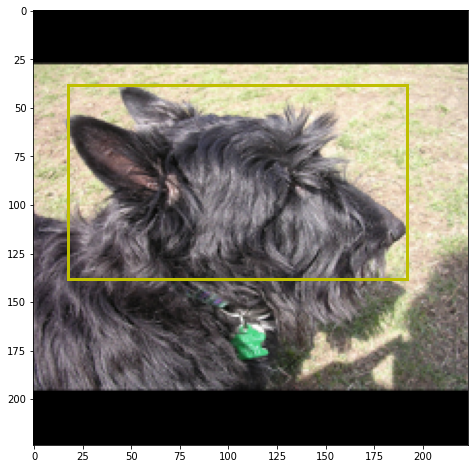

2659 it is dog


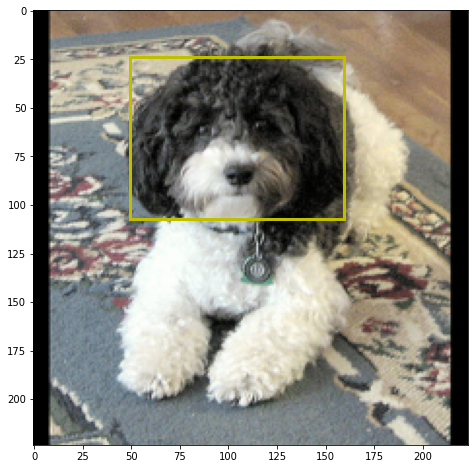

3156 it is cat


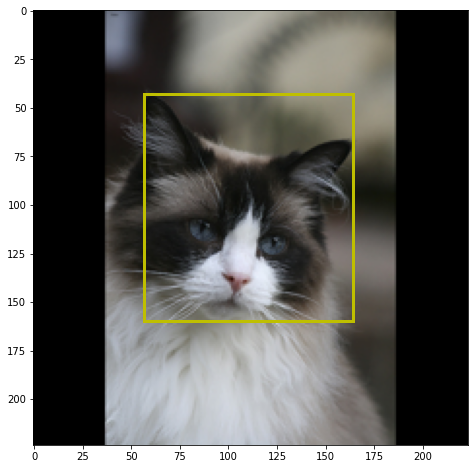

737 it is dog


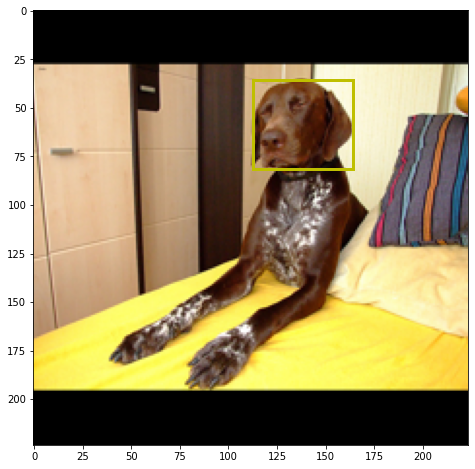

2181 it is cat


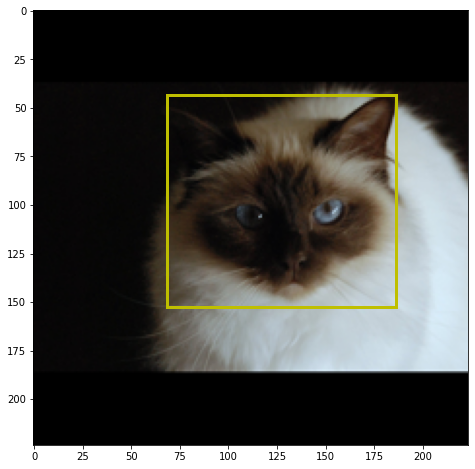

1118 it is dog


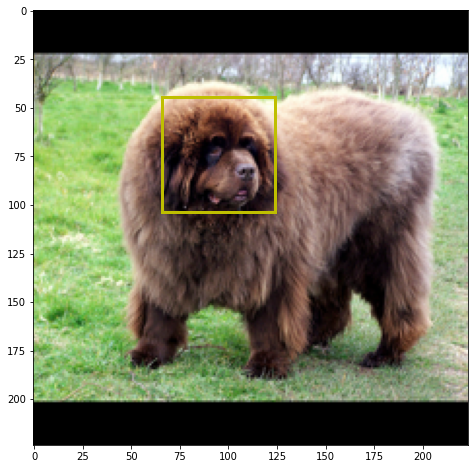

In [65]:
for _ in range(6):
    i = np.random.randint(len(data_pros))
    image, species, bounding_box = data_pros[i]
    if species == 0:
        print(i, "it is cat")
    elif species == 1:
        print(i, "it is dog")
    else:
        print("ERROR FOUND: This is of invalid species type")
    plot_with_box(image, bounding_box)

### Entrenamiento de los datos
Se crean los datos correspondientes para el entrenamiento del modelo. El modelo, como anteriormente dijimos, busca clasificar que tipo de animal es. Esto lo hace gracias al preprocesamiento de datos ya realizado.

In [68]:
x_train = []
y_class_train = []
y_box_train = []
x_validation = []
y_class_validation = []
y_box_validation = []
validation_split = 0.2
for image, species, bounding_box in data_pros:
    if np.random.random() > validation_split:
        x_train.append(preprocess_input(image))
        y_class_train.append(species)
        y_box_train.append(bounding_box)
    else:
        x_validation.append(preprocess_input(image))
        y_class_validation.append(species)
        y_box_validation.append(bounding_box)
x_train = np.array(x_train)
y_class_train = np.array(y_class_train)
y_box_train = np.array(y_box_train)
x_validation = np.array(x_validation)
y_class_validation = np.array(y_class_validation)
y_box_validation = np.array(y_box_validation)


### Modelo
Se comienza a realizar el modelo. El modelo escogido fue la red pre entrenada _ResNet_. Dado que es un modelo ya pre entrenado, garantiza buenos resultados por lo tanto garantiza buena clasificación. Esto es importante ya que es un modelo grande. Sin embargo, por esta misma razón y la cantidad de datos, el tiempo en entrenar finalmente es muy grande.

In [69]:
base_model1 = ResNet50(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
chopped_resnet1 = Model(inputs=[base_model1.input], outputs=[base_model1.layers[90].output])
classification_output1 = GlobalAveragePooling2D()(chopped_resnet1.output)
classification_output1 = Dense(units=1, activation='sigmoid')(classification_output1)
localization_output1 = Flatten()(chopped_resnet1.output)
localization_output1 = Dense(units=4, activation='relu')(localization_output1)
model1 = Model(inputs=[chopped_resnet1.input], outputs=[classification_output1, localization_output1])
model1.summary()

94781440/94765736 [==============================] - 5s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________

In [70]:
model1.compile(optimizer='adam', metrics=['accuracy'],loss=['binary_crossentropy', 'mse'],loss_weights=[800, 1]  )
#lets run it through 10 epochs
history2=model1.fit(x_train, [y_class_train, y_box_train], validation_data=(x_validation, [y_class_validation, y_box_validation]),epochs=10,verbose=True)
history2

Epoch 1/10
93/93 [==============================] - 652s 7s/step - loss: 1048.0326 - dense_loss: 0.3715 - dense_1_loss: 750.8060 - dense_accuracy: 0.8302 - dense_1_accuracy: 0.7949 - val_loss: 3010.7334 - val_dense_loss: 2.5828 - val_dense_1_loss: 944.4788 - val_dense_accuracy: 0.3357 - val_dense_1_accuracy: 0.7891
Epoch 2/10
93/93 [==============================] - 666s 7s/step - loss: 523.6560 - dense_loss: 0.1733 - dense_1_loss: 385.0381 - dense_accuracy: 0.9250 - dense_1_accuracy: 0.8325 - val_loss: 3077.5403 - val_dense_loss: 1.7105 - val_dense_1_loss: 1709.1073 - val_dense_accuracy: 0.3357 - val_dense_1_accuracy: 0.7891
Epoch 3/10
93/93 [==============================] - 664s 7s/step - loss: 392.2404 - dense_loss: 0.0949 - dense_1_loss: 316.3564 - dense_accuracy: 0.9620 - dense_1_accuracy: 0.8453 - val_loss: 2814.1125 - val_dense_loss: 2.1589 - val_dense_1_loss: 1087.0012 - val_dense_accuracy: 0.3357 - val_dense_1_accuracy: 0.7891
Epoch 4/10
93/93 [==============================]

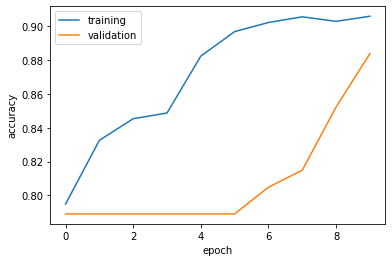

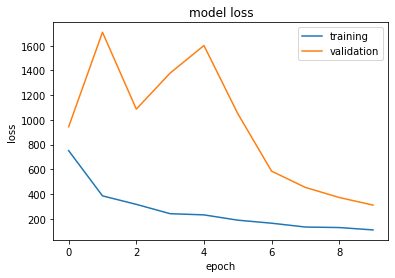

In [76]:
def plot_training_history(history, model):
    plt.plot(history.history['dense_1_accuracy'])
    plt.plot(history.history['val_dense_1_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()
    plt.plot(history.history['dense_1_loss'])
    plt.plot(history.history['val_dense_1_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()
plot_training_history(history2, model1)

it is a Cat by ResNet
intersection of union = 0.528158383392003


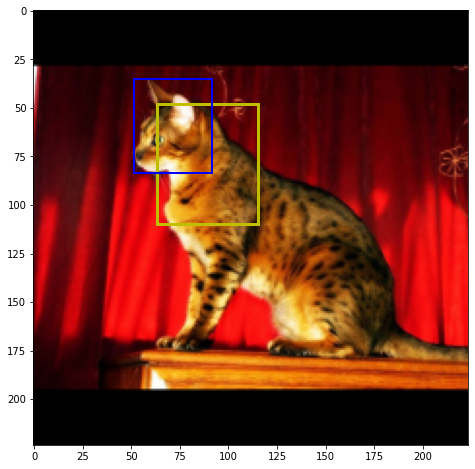

it is a dog by ResNet
intersection of union = 0.732268281247883


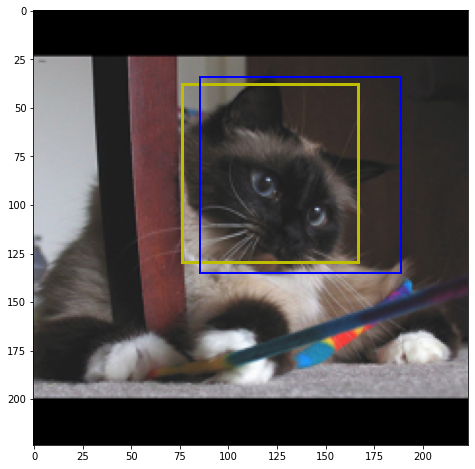

it is a dog by ResNet
intersection of union = 0.7641919331691814


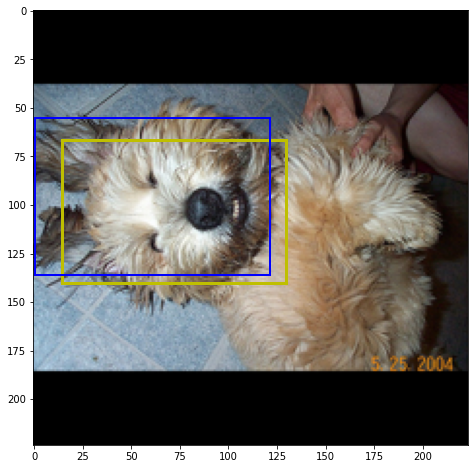

In [77]:
for _ in range(3):
    i = np.random.randint(len(data_pros))
    img, species, true_bounding_box = data_pros[i]
    pred = model1.predict(np.array([preprocess_input(img)]))
    if pred[0][0] < .5:
        print("it is a Cat by ResNet")
    else:
        print("it is a dog by ResNet")
    plot_with_box(img, Bounding_Box(*pred[1][0]), true_bounding_box)

### FPS

In [82]:
import time

seg = time.time()
img, species, true_bounding_box = data_pros[0]
pred = model1.predict(np.array([preprocess_input(img)]))

tiempo = time.time()-seg
print(1/tiempo)

7.298732124274791


### Preguntas

1. ¿Los modelos funcionaron de acuerdo a sus expectativas?

    En realidad, observando los resultados obtenidos, podemos ver que el modelo implementado sí funciona de acuerdo a nuestras expectativas, ya que se logran identificar los objetos, en este caso las caras de los animales de forma satisfactoria, y clara. Además de esto, al implementar el modelo, este logra clasificarlas también con un accuracy muy bueno incluso cuando las épocas no son tantas.
    

2. ¿Qué puede decir de la complejidad para hacer funcionar los modelos?

    La complejidad para hacer funcionar estos modelos es alta, sin embargo, es una buena manera de implementar una red pre entrenada. Cabe aclarar que los resultados obtenidos dependerán del dataset que se utilice. Además en el resumen del modelo, podemos observar que a diferencia de otros modelos, la cantidad de paramentros entrenables no es tan alta como lo sería con el modelo *Xception* ni tan bajo como *Mobile Net*. Esto se puede visualizar en el blog.
    

3. Basado en lo que vimos en el curso de visión, ¿cómo desarrollarían un algoritmo que hiciera localización o detección de objetos, sin utilizar redes convolucionales? Explique paso a paso.

    Una manera de realizar un algoritmo de localización de objetos, o detección de objetos, con la información y las herramientas aprendidas en el curso podría ser la siguiente: en primer lugar, con operaciones morfológicas, como detección de bordes, encontrar los objetos, en este caso, la cara de los animales. Posteriormente, por medio de segmentación de imágenes, dividir el elemento que queremos localizar (la cara), y así saber dónde está ubicado. 
    

4. ¿Qué tan rápido es el algortimo para realizar la detección? ¿Cual es la frecuencia máxima del video (fps-frames per second) para las cuales este tipo de red se podria considerar un modelo en tiempo real?

     No es tan rápido como desearíamos sin embargo, la cantidad de datos es muy grande así que se esperaría que se tomase su tiempo. La última operación realizada nos muestra que por imagen se demora $7.29$ fps. Esto se haya teniendo en cuenta la predicción del modelo y una imagen del dataset.


5. A modo de conclusión, ¿Qué opina de estos modelos?

    Estos modelos son interesantes en cuanto a que permiten realizar tareas de visión por computadora de manera, en teoría, rápida y fácil. Sin embargo, tienen un grado alto de complejidad en su implementación y entendimiento, por lo cual sería muy interesante aprender de fondo el tema para poder entender del todo su implementación. Aun así, es atractivo ver la eficancia del modelo al clasificar los animales.